# Analysis of Israeli Restaurants in New York City 

### 1. Install all the libraries

In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import urllib, json

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



### 2. Get data on Israeli restaurants in New York from Foursquare

In [4]:
CLIENT_ID = 'ADGZI2EDUVQ5KWEC2CR3J4P1AFWGPFGMDEPPRWRLAWWYZMOW' # my Foursquare ID
CLIENT_SECRET = '5H3CTSKCDIY2UJTZUWDEEMD5WCAGMK30KS2AHO0XMF15VXMG' # my Foursquare Secret
VERSION = '20180605'

In [5]:
radius = 15000
limit=200
latitude=40.7128
longitude=-74.0060
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&query={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    "Israeli",
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    limit)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ADGZI2EDUVQ5KWEC2CR3J4P1AFWGPFGMDEPPRWRLAWWYZMOW&client_secret=5H3CTSKCDIY2UJTZUWDEEMD5WCAGMK30KS2AHO0XMF15VXMG&query=Israeli&v=20180605&ll=40.7128,-74.006&radius=15000&limit=200'

In [75]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
israeli_venues=json_normalize(venues)
filtered_columns = ['venue.name', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng', 'venue.id']
israeli_venues = israeli_venues.loc[:, filtered_columns]
israeli_venues=israeli_venues.rename(columns={"venue.name":"Name", "venue.location.postalCode":"Zipcode", "venue.location.lat":"Latitude", "venue.location.lng":"Longitude", "venue.id":"ID"})
israeli_venues.dropna(inplace=True)

Find and rename duplicates (when two locations exist with the same name)

In [76]:
dup = israeli_venues[israeli_venues.duplicated("Name")]
dup["Name"] = dup["Name"] + " 1"
dup

C:\Users\elama\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,Zipcode,Latitude,Longitude,ID
13,12 Chairs 1,11249,40.714384,-73.965148,54df9be0498e8ba3ab1d01fb
28,Taïm 1,10010,40.742256,-73.993144,5bf34fca018cbb002c99be4a
30,Jack's Wife Freda 1,10014,40.729999,-74.003584,549430f6498edcbb09ab35c0
33,The Hummus & Pita Co 1,10011,40.739269,-73.995493,4f331c5ce4b05255bdf07d27
57,Hummus Kitchen 1,10028,40.776372,-73.952828,4a355b56f964a520dc9c1fe3
90,Olympic Pita 1,10012,40.730038,-74.000310,5d82e915f8f15c000890c96f


In [77]:
israeli_venues2 = israeli_venues.drop_duplicates("Name")
israeli_venues = israeli_venues2.append(dup)
israeli_venues = israeli_venues.reset_index(drop=True)

In [78]:
israeli_venues.tail(10)

,Name,Zipcode,Latitude,Longitude,ID
80,Alenbi Kitchen,11225,40.666392,-73.950696,59ee92dbe7a23778c5d660fb
81,Zion Kosher Market (ציון),11218,40.641111,-73.985600,4bd5f36a4e32d13a47cac180
82,Flora Cafe,07114,40.697579,-74.175022,549464b1498e855d5f4f64a0
83,Sunflower Cafe - Brooklyn,11229,40.608049,-73.960099,4562f9fdf964a520a13d1fe3
84,12 Chairs 1,11249,40.714384,-73.965148,54df9be0498e8ba3ab1d01fb
85,Taïm 1,10010,40.742256,-73.993144,5bf34fca018cbb002c99be4a
86,Jack's Wife Freda 1,10014,40.729999,-74.003584,549430f6498edcbb09ab35c0
87,The Hummus & Pita Co 1,10011,40.739269,-73.995493,4f331c5ce4b05255bdf07d27
88,Hummus Kitchen 1,10028,40.776372,-73.952828,4a355b56f964a520dc9c1fe3
89,Olympic Pita 1,10012,40.730038,-74.000310,5d82e915f8f15c000890c96f


### 3. Assign borough according to zipcode

Get a list of zipcodes for each borough

In [79]:
zips=pd.read_html("https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm", index_col=None)
zips=zips[0]
zips=zips.drop("Neighborhood", axis=1)
zips = zips.groupby(['Borough'])['ZIP Codes'].apply(', '.join).reset_index()
zips.head()

,Borough,ZIP Codes
0,Bronx,"10453, 10457, 10460, 10458, 10467, 10468, 1045..."
1,Brooklyn,"11212, 11213, 11216, 11233, 11238, 11209, 1121..."
2,Manhattan,"10026, 10027, 10030, 10037, 10039, 10001, 1001..."
3,Queens,"11361, 11362, 11363, 11364, 11354, 11355, 1135..."
4,Staten Island,"10302, 10303, 10310, 10306, 10307, 10308, 1030..."


In [80]:
Bronx=zips.iat[0, 1]
Brooklyn=zips.iat[1, 1]
Manhattan=zips.iat[2, 1]
Queens=zips.iat[3, 1]
StatenIsland=zips.iat[4, 1]

Insert a "Borough" column

In [81]:
israeli_venues["Zipcode"].astype(str)
israeli_venues["Borough"]=""

Assign a borough to each venue according to its zipcode

In [82]:
index = 0
for venue in israeli_venues["Name"]:
    try:
        zipcode = israeli_venues.iat[index, 1]
    except IndexError:
        print("Something went wrong")
    index = israeli_venues[israeli_venues["Name"] == venue].index.values.astype(int)[0]
    zipcode = israeli_venues.iat[index, 1]
    if zipcode in Manhattan:
        israeli_venues.at[index,"Borough"]="Manhattan"
    elif zipcode in Brooklyn:
        israeli_venues.at[index,"Borough"]="Brooklyn"
    elif zipcode in Bronx:
        israeli_venues.at[index,"Borough"]="Bronx"
    elif zipcode in Queens:
        israeli_venues.at[index,"Borough"]="Queens"
    elif zipcode in StatenIsland:
        israeli_venues.at[index,"Borough"]="StatenIsland"
    else:
        israeli_venues.at[index,"Borough"]=None

Drop venues not assigned to any borough

In [83]:
israeli_venues = israeli_venues.dropna()

In [84]:
israeli_venues = israeli_venues.reset_index(drop=True)

Get count of restaurants in each borough

In [85]:
rest_in_borough = israeli_venues['Borough'].value_counts()
rest_in_borough

Manhattan    64
Brooklyn     21
Queens        2
Name: Borough, dtype: int64

In [86]:
x = list(rest_in_borough.index)
y = list(rest_in_borough[:])
label = "Number of Israeli restaurants by borough"

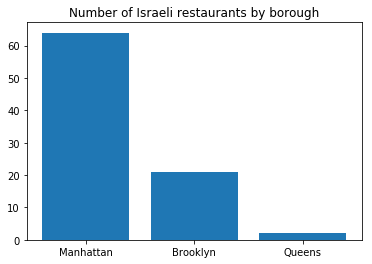

In [87]:
plt.bar(x, y)
plt.title(label)
plt.show()

### 4. Get venue ratings and number of ratings for each venue

In [88]:
israeli_venues["Rating"]=""
israeli_venues["No. of Ratings"]=""

Code not run everytime to avoid multiple premium requests, ratings were received once and stored as a list

In [18]:
#for venue_id in israeli_venues["ID"]:
#    index = israeli_venues[israeli_venues["ID"] == venue_id].index.values.astype(int)[0]
#    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
#    result = requests.get(url).json()
#    try:
#        print(result['response']['venue']['rating'])
#    except:
#        last_venues.at[index,"Rating"] = None
#        last_venues.at[index,"No. of Ratings"] = None
#        continue
#    israeli_venues.at[index,"Rating"]=result['response']['venue']['rating']
#    israeli_venues.at[index,"No. of Ratings"]=result['response']['venue']['ratingSignals']

In [89]:
ratings = [9.0, 8.9, 9.3, 8.7, 8.2, 9.2, 8.7, 8.7, 8.6, 8.6, 8.4, 8.7, 8.6, 8.7, 9.2, 7.7, 8.9, 8.0, 8.5, 9.0, 8.2, 7.8, 8.6, 8.5, 8.8, 7.9, 9.0, 8.4, 9.3, 8.6, 6.9, 8.4, 8.5, 8.6, 6.9, 7.9, 9.0, 7.7, 8.2, 8.3, 8.3, 9.3, 8.2, 6.8, 7.5, 8.6, 7.9, 7.5, 7.7, 8.2, 7.5, 9.1, 8.1, 7.6, 6.5, 8.0, 7.3, 7.2, 6.8, 7.7, 8.0, 6.6, 7.3, None, 8.3, None, 9.0, 6.4, 8.7, 5.9, None, None, None, None, 8.3, None, 7.5, 5.5, None, None, None, 6.0, 8.8, 8.8, 8.3, 7.5, None]
no_of_ratings = [1214.0, 588.0, 295.0, 223.0, 307.0, 1075.0, 251.0, 826.0, 263.0, 22.0, 117.0, 428.0, 310.0, 2388.0, 114.0, 85.0, 534.0, 19.0, 78.0, 432.0, 119.0, 29.0, 93.0, 910.0, 783.0, 43.0, 358.0, 536.0, 1790.0, 303.0, 21.0, 223.0, 873.0, 74.0, 13.0, 181.0, 420.0, 246.0, 249.0, 41.0, 29.0, 1528.0, 181.0, 29.0, 142.0, 22.0, 295.0, 108.0, 54.0, 256.0, 166, 5726, 512, 59, 178, 97, 166, 59, 37, 190, 389, 23, 154, None, 252, None, 593, 19, 2444, 90, None, None, None, None, 82, None, 355, 42, None, None, None, 33, 42, 1054, 688, 122, None]

In [90]:
israeli_venues["Rating"] = ratings
israeli_venues["No. of Ratings"] = no_of_ratings

Drop restaurants without a rating

In [91]:
israeli_venues = israeli_venues.dropna()
israeli_venues = israeli_venues.reset_index(drop=True)

Get average rating and number of ratings of all Israeli restaurants in NYC

In [92]:
avg_rating = israeli_venues["Rating"].sum() / israeli_venues["Rating"].count()
avg_no_ratings = israeli_venues["No. of Ratings"].sum() / israeli_venues["No. of Ratings"].count()

In [93]:
print("The average rating of all Israeli restaurants in NYC is %.1f" % (avg_rating))
print("The average number of ratings of all Israeli restaurants in NYC is %.1f" % (avg_no_ratings))

The average rating of all Israeli restaurants in NYC is 8.1
The average number of ratings of all Israeli restaurants in NYC is 435.4


Get average rating of restaurants in each borough

In [115]:
avg = israeli_venues.groupby("Borough").mean()
avg

,Latitude,Longitude,Rating,No. of Ratings
Borough,,,,
Brooklyn,40.678877,-73.964310,8.253846,295.615385
Manhattan,40.747277,-73.987246,8.068852,477.196721
Queens,40.723832,-73.854504,8.150000,69.000000


In [144]:
x = avg.index
y1 = avg["Rating"]
y2 = avg["No. of Ratings"]

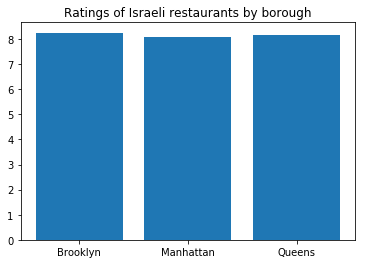

In [145]:
plt.bar(x1, y1)
plt.title("Ratings of Israeli restaurants by borough")
plt.show()

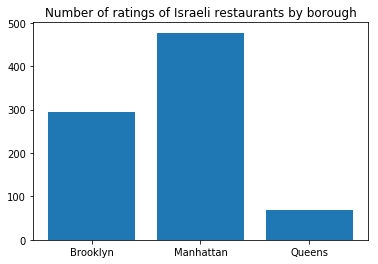

In [146]:
plt.bar(x1, y2)
plt.title("Number of ratings of Israeli restaurants by borough")
plt.show()

Top 10 rated venues

In [176]:
top10 = israeli_venues.sort_values("Rating", ascending = False).head(10)
top10 = top10[["Name", "Rating"]].reset_index(drop=True)

In [177]:
top10

,Name,Rating
0,Breads Bakery,9.3
1,Miss Ada,9.3
2,Cafe Mogador,9.3
3,Nish Nūsh,9.2
4,Taïm,9.2
5,Katz's Delicatessen,9.1
6,Taboon,9.0
7,Oasis,9.0
8,Blue Hill,9.0
9,Zizi Limona,9.0


Map of NYC with Israeli restaurants marked with color-coded markers

In [191]:
# assign color to markers according to rating
def get_color(rating):
    if rating >= 9.0:
        color = "red"
    elif rating < 9.0 and rating >=8.0:
        color = "orange"
    elif rating < 8.0 and rating >=7.0:
        color = "yellow"
    elif rating < 7.0 and rating >=6.0:
        color = "green"
    elif rating < 6.0:
        color = "blue"
    return color

In [193]:
latitude=40.7128
longitude=-74.0060
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, name, rating in zip(israeli_venues['Latitude'], israeli_venues['Longitude'], israeli_venues['Name'], israeli_venues['Rating']):
    label = '{}, {}'.format(name, rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=get_color(rating),
        fill=True,
        fill_color=get_color(rating),
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
map_newyork